In [4]:
from functions.data_loading import get_wind_direction
from matplotlib import pyplot as plt
from functions.data_processing import prepare_wind_data

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

In [5]:
gardermoen = get_wind_direction("GARDERMOEN")

In [6]:
gardermoen

,source,time,wind_direction,wind_speed
0,SN4780:0,2023-01-01T00:00:00.000Z,43,1.2
1,SN4780:0,2023-01-01T00:20:00.000Z,340,2.6
2,SN4780:0,2023-01-01T00:50:00.000Z,320,3.1
3,SN4780:0,2023-01-01T01:00:00.000Z,27,1.7
4,SN4780:0,2023-01-01T01:20:00.000Z,340,3.1
...,...,...,...,...
24651,SN4780:0,2023-12-31T22:20:00.000Z,40,5.1
24652,SN4780:0,2023-12-31T22:50:00.000Z,40,5.1
24653,SN4780:0,2023-12-31T23:00:00.000Z,51,5.1
24654,SN4780:0,2023-12-31T23:20:00.000Z,40,5.1


In [7]:
df = prepare_wind_data(gardermoen)

In [8]:
df

,wind_direction,wind_speed,x,y
time,,,,
2023-01-01 00:00:00+00:00,0.750492,1.200000,0.818398,0.877624
2023-01-01 00:00:01+00:00,0.749575,1.201167,0.818388,0.879228
2023-01-01 00:00:02+00:00,0.748659,1.202333,0.818377,0.880832
2023-01-01 00:00:03+00:00,0.747743,1.203500,0.818362,0.882437
2023-01-01 00:00:04+00:00,0.746826,1.204667,0.818346,0.884043
...,...,...,...,...
2023-12-31 23:49:56+00:00,0.872277,5.100000,3.905555,3.279732
2023-12-31 23:49:57+00:00,0.872374,5.100000,3.905873,3.279353
2023-12-31 23:49:58+00:00,0.872471,5.100000,3.906191,3.278974


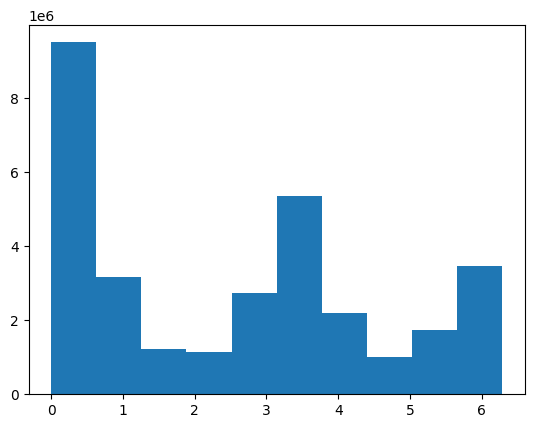

In [9]:
plt.hist(df["wind_direction"])
plt.show()

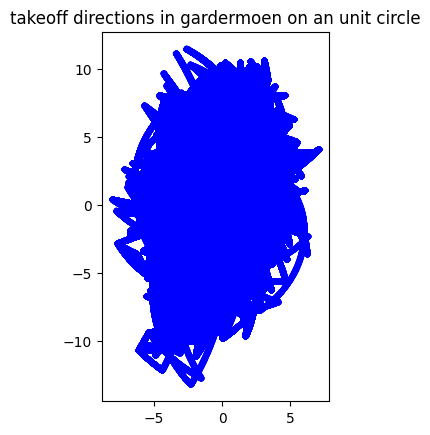

In [10]:
plt.plot(df["x"], df["y"], '.', color="blue", scalex=False, scaley=False)
plt.title(f"takeoff directions in gardermoen on an unit circle")
plt.axis('scaled')

plt.show()

In [1]:
device = (torch.device('cuda') 
          if torch.cuda.is_available()
          else torch.device('cpu'))

NameError: name 'torch' is not defined

In [ ]:
class MyMLP(nn.Module):

    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, output_size)

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.fc4(out)
        return out

In [ ]:
from datetime import datetime


def train(n_epochs, optimizer, model, train_loader, loss_function):
    n_batch = len(train_loader)
    losses_train = []
    model.train()
    optimizer.zero_grad(set_to_none=True)

    for epoch in range(1, n_epochs + 1):

        loss_train = 0.0
        for imgs, labels in train_loader:
            # data
            imgs = imgs.to(dtype = torch.float, device = device)
            labels = labels.to(dtype = torch.float, device = device)
            
            #predictions
            outputs = model(imgs)
            
            # calculate loss
            loss = nn.MSELoss()(outputs, labels)
            loss.backward()
            
            # optimize
            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()

        losses_train.append(loss_train / n_batch)

        if epoch == 1 or epoch % 10 == 0:
            print('{}  |  Epoch {}  |  Training loss {:.3f}'.format(
                datetime.now().time(), epoch, loss_train / n_batch))
    return losses_train

In [ ]:
n_models = 3

modelparams = {
  f"model{i}": {
    "lr": 0.01,
    "momentum": 0.9,
    "weight_decay": 0
  } for i in range(n_models)
}

modelparams["model1"].update({
  "momentum": 0.5,
  "weight_decay": 0.005,
})

modelparams["model2"].update({
  "momentum": 0.5,
})

In [ ]:
trainedmodels = {}
losses = {}
loss_function = nn.MSELoss()
loader = torch.utils.data.DataLoader(training, batch_size=64, shuffle=True)

for name, params in modelparams.items():
  model = MyMLP()
  model.to(device = device)
  optimizer = optim.SGD(model.parameters(), **params)

  print(f"{name}: ", "  |  ".join(map(lambda x: f"{str(x[0])}: {str(x[1])}",params.items())))
  losses[name]=train(40, optimizer, model, loader, loss_function)
  trainedmodels[name] = model